Este código lo que hace es tomar datos de las magnitudes "V" e "I" de una fuente desconocida y trata de identificar qué tipo de estrella variable es. Para eso analiza el período, la diferencia de magnitud en el filtro "V", etc.

Luego se trató de identificar exactamente qué fuente es, determinando el período con el método Monte Carlo y luego buscando fuentes en el ASAS_SN. Lamentablemente no se pudo identificar una fuente sino que hay ~60 que son compatibles.

El código requiere los archivos estrella1.txt, V.txt y asassn-catalog.csv para funcionar

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas
plt.style.use('dark_background')

In [2]:
plt.style.use('dark_background')

In [3]:
FI = np.loadtxt('estrella1.txt', delimiter=' ', skiprows=2, usecols=(0,1,2)) # Filtro I
FV = np.loadtxt('V.txt', delimiter=' ', skiprows=1) # Filtro V
# Defino tiempo, magnitudes y errores
TI = FI[:,0]
I = FI[:,1]
ERRI = FI[:,2]
TV = FV[:,0]
V = FV[:,1]
ERRV = FV[:,2]

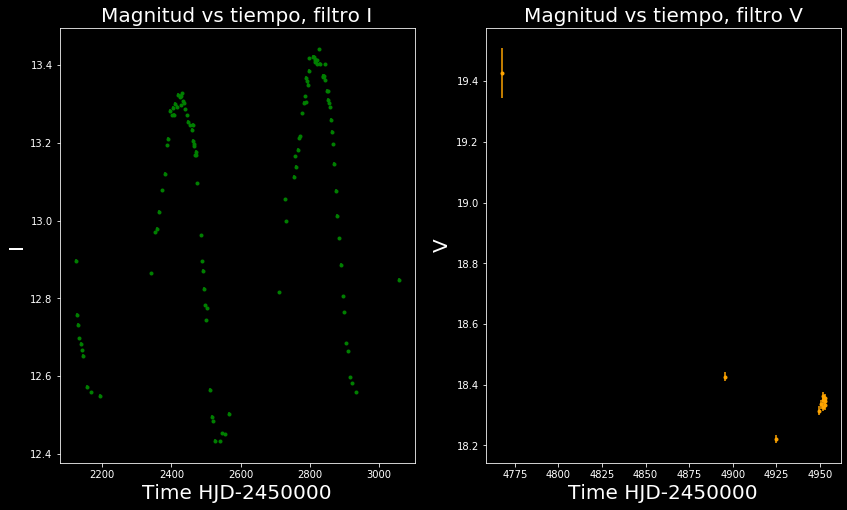

In [4]:
# Magnitud vs tiempo
fig, ax = plt.subplots(1, 2, figsize = (14,8))

ax[0].errorbar(TI, I, yerr=ERRI, color='green', fmt='.')
ax[1].errorbar(TV, V, yerr=ERRV, color='orange', fmt='.');


ax[0].set_title('Magnitud vs tiempo, filtro I', fontsize=20)
ax[0].set_xlabel('Time HJD-2450000', fontsize=20)
ax[0].set_ylabel('I', fontsize=20)
ax[1].set_title('Magnitud vs tiempo, filtro V', fontsize=20)
ax[1].set_xlabel('Time HJD-2450000', fontsize=20)
ax[1].set_ylabel('V', fontsize=20);


Finding optimal frequency:
 - Estimated peak width = 0.00674
 - Using 5 steps per peak; omega_step = 0.00135
 - User-specified period range:  2.9e+02 to 5e+02
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 387.70379982308935


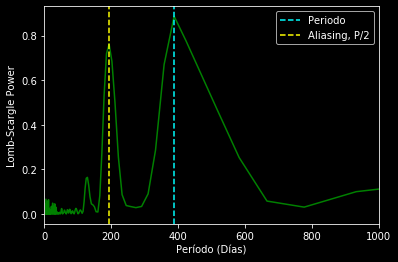

In [5]:
# Periodograma
from gatspy.periodic import LombScargleFast
from gatspy import datasets, periodic #Importo "periodic" para definir el modelo

model = periodic.LombScargleFast(fit_period=True) # Defino modelo
model.optimizer.period_range = (300, 500)        # Rango para buscar períodos
model.fit(TI, I, ERRI)                         # Ingreso mis datos al modelo y ajusto
periods, power = model.periodogram_auto()     # Obtengo resultados
# Obtengo el pico
period = model.best_period
print("period = {0}".format(period))

# Grafico:
fig, ax = plt.subplots()
ax.plot(periods, power, color='green')
ax.axvline(period, ls='--', color='cyan', label='Periodo')
ax.axvline(period/2., ls='--', color='yellow', label='Aliasing, P/2')
ax.set(xlim=(0, 1000), xlabel='Período (Días)', ylabel='Lomb-Scargle Power');

ax.legend()

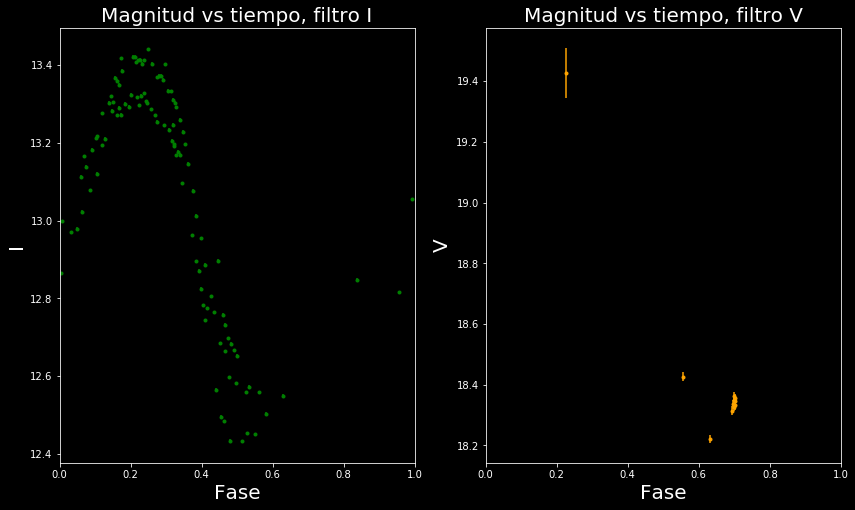

In [19]:
# Magnitud en fase
fig, ax = plt.subplots(1, 2, figsize = (14,8))

ax[0].errorbar(TI/period %1, I, yerr=ERRI, color='green', fmt='.')
ax[1].errorbar(TV/period %1, V, yerr=ERRV, color='orange', fmt='.');


ax[0].set_title('Magnitud vs tiempo, filtro I', fontsize=20)
ax[0].set_xlabel('Fase', fontsize=20)
ax[0].set_ylabel('I', fontsize=20)
ax[0].set_xlim(0,1)
ax[1].set_title('Magnitud vs tiempo, filtro V', fontsize=20)
ax[1].set_xlabel('Fase', fontsize=20)
ax[1].set_ylabel('V', fontsize=20)
ax[1].set_xlim(0,1);

In [7]:
# Calculo la máxima diferencia de flujo en V
DifV = max(V)-min(V)
DifV

1.2059999999999995

Tengo un periodo de ~400 años, una máxima diferencia de amplitud en V de ~1.2 mag y tengo que la amplitud en I no es la misma para cada ciclo. Todo ésto me sugiere que estoy ante una variable Mira, pero debería confirmarlo encontrando la fuente exacta

In [8]:
%%time
# Usaré el método Monte Carlo para ver si puedo tener un mejor período, traigo mi función
from Misfunciones import Perturbador
# Importo un limpiador de prints en pantalla
# https://stackoverflow.com/questions/24816237/ipython-notebook-clear-cell-output-in-code/24818304
from IPython.display import clear_output
from gatspy.periodic import LombScargleFast
Periodos = []
ij = 0
while ij<1000:
    # Muestra perturbada
    MPert = Perturbador(TI, I, ERRI)
    # Calculo el período para cada muestra perturbada
    model = periodic.LombScargleFast(fit_period=True)
    model.optimizer.period_range = (300, 500)      
    model.fit(MPert[0], MPert[1], MPert[2])
    clear_output()
    # Obtengo el pico
    period = model.best_period;
    # ---------------------------------------------------------------------
    # Lo agrego a mi arreglo de Periodos
    Periodos.append(period)
    ij = ij + 1

CPU times: user 15.7 s, sys: 852 ms, total: 16.5 s
Wall time: 16.7 s


Promedio: 391.1 +- 1.9 días


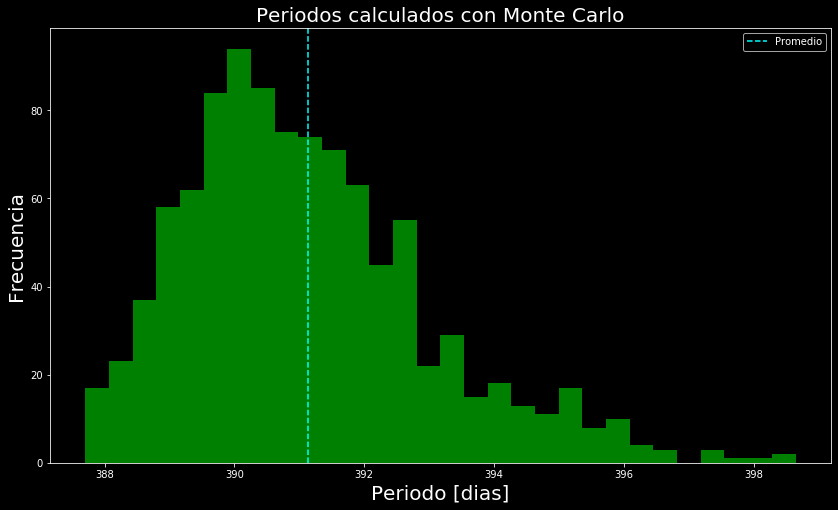

In [9]:
# Calculo media y desviación estándar
Media = np.mean(Periodos)
Desviacion = np.std(Periodos)
print('Promedio:',round(Media,1), '+-', round(Desviacion,1), 'días')

# Grafico
fig, ax = plt.subplots(1, 1, figsize = (14,8))

ax.hist(Periodos, bins=30, color='green')
ax.axvline(Media, ls='--', color='cyan', label='Promedio')

ax.set_title('Periodos calculados con Monte Carlo', fontsize=20)
ax.set_xlabel('Periodo [dias]', fontsize=20)
ax.set_ylabel('Frecuencia', fontsize=20)
ax.legend();

Ahora que encontré el rango del período, buscaré las fuentes en el catálogo ASAS-SN que esten en ese rango

In [10]:
import pandas
# Importo catálogo ASASS
M = pandas.read_csv('asassn-catalog.csv', usecols=['period', 'Type']) 

In [11]:
# Defino cantidades de interés
Per = M['period']
Type = M['Type']

In [12]:
# Busco las fuentes Mira en el rango del período que encontré con Monte Carlo
ij_Miras = []
ij = 0
while ij<len(Per):
    if Per[ij]>(Media-Desviacion) and Per[ij]<(Media+Desviacion):
        if Type[ij]=='M' or Type[ij]=='M:':
            ij_Miras.append(ij)
    ij = ij + 1

Cantidas de fuentes compatibles: 60


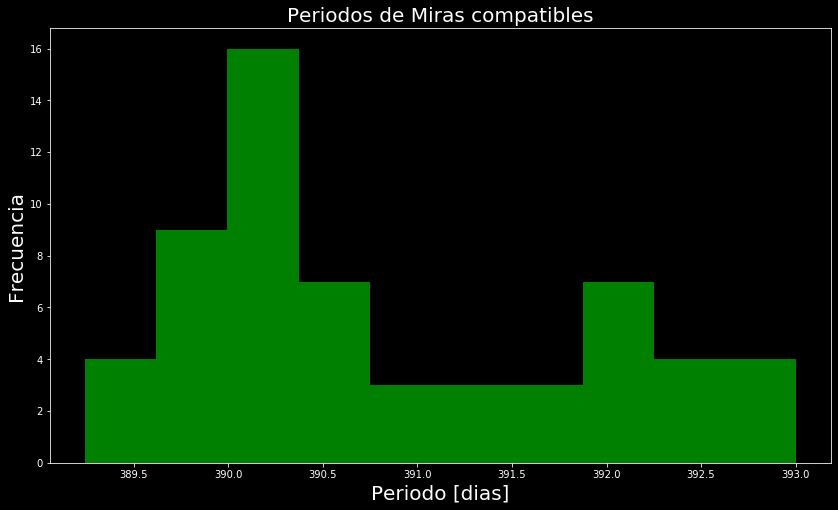

In [15]:
# Cuento las fuentes compatibles y hago el histograma
print('Cantidas de fuentes compatibles:', len(ij_Miras))
fig, ax = plt.subplots(1, 1, figsize = (14,8))

ax.hist(Per[ij_Miras], color='green')

ax.set_title('Periodos de Miras compatibles', fontsize=20)
ax.set_xlabel('Periodo [dias]', fontsize=20)
ax.set_ylabel('Frecuencia', fontsize=20);

No es posible identificar la fuente exacta